<a href="https://colab.research.google.com/github/AcidCannon/CMPUT466-Mini-project/blob/master/task3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
from torchvision import datasets, transforms
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
# from torchvision.utils import save_image
import matplotlib.pyplot as plt

In [0]:
config = {}
config['training_size'] = 50000
config['training_batch_size'] = 64
config['training_shuffle'] = True
config['device'] = 'gpu'
config['generator_learning_rate'] = 0.001
config['generator_weight_decay'] = 0.001
config['discriminator_learning_rate'] = 0.001 
config['discriminator_weight_decay'] = 0.001
config['algorithm'] = 'Generative Adversarial Network'
config['number_of_epochs'] = 1000
config['discriminator_real_loss_coe'] = 1.0
config['discriminator_fake_loss_coe'] = 1.0
config['mode'] = 'test' # 'fresh_start' 'load_and_train' 'test' 'demo'

In [404]:
if config['mode'] == 'demo':
  pass
  # load last time trained model and data
  # FILL HERE WHEN DONE
else:
  # mount google drive to save checkpoints
  from google.colab import drive
  drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
def load_data(config):
  MNIST_training_set = datasets.MNIST(root='data', train=True, download=True, transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.5,), (0.5,))
                  ]))
  
  MNIST_training_set = torch.utils.data.Subset(MNIST_training_set, range(0, config['training_size']))

  training_dataloader = torch.utils.data.DataLoader(dataset=MNIST_training_set, batch_size=config['training_batch_size'], shuffle=config['training_shuffle'])

  return training_dataloader

In [0]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.fc1 = nn.Linear(100, 32)
    self.fc2 = nn.Linear(32, 64)
    self.fc3 = nn.Linear(64, 128)
    self.fc4 = nn.Linear(128, 784)
  
  def forward(self, x):
    x = F.leaky_relu(self.fc1(x), 0.2, True)
    x = F.leaky_relu(self.fc2(x), 0.2, True)
    x = F.leaky_relu(self.fc3(x), 0.2, True)
    return torch.tanh(self.fc4(x))

In [0]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.fc1 = nn.Linear(784, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 32)
    self.fc4 = nn.Linear(32, 1)
  
  def forward(self, x):
    # using dropout to prevent overfitting
    x = F.leaky_relu(self.fc1(x), 0.2, True)
    x = F.dropout(x)
    x = F.leaky_relu(self.fc2(x), 0.2, True)
    x = F.dropout(x)
    x = F.leaky_relu(self.fc3(x), 0.2, True)
    x = F.dropout(x)
    return torch.sigmoid(self.fc4(x))

In [0]:
def discriminator_train(config, data, discriminator_optimizer, discriminator, generator, loss_function):
  # set gradient to be zero
  discriminator_optimizer.zero_grad()
  
  real_data = (data.view(-1, 784)).to(config['device'])
  real_target = (torch.ones(data.shape[0], 1)).to(config['device'])

  # forward propagation for real
  output = discriminator(real_data)
  # compute loss for real
  discriminator_real_loss = loss_function(output, real_target)

  fake_data = generator(torch.randn(data.shape[0], 100).to(config['device']))
  fake_target = (torch.zeros(data.shape[0], 1)).to(config['device'])

  # forward propagation for fake
  output = discriminator(fake_data)
  # compute loss for fake
  discriminator_fake_loss = loss_function(output, fake_target)

  # compute total loss as a combination of real loss and fake loss
  discriminator_total_loss = config['discriminator_real_loss_coe']*discriminator_real_loss + config['discriminator_fake_loss_coe']*discriminator_fake_loss
  
  # backward propagation for total loss
  discriminator_total_loss.backward()
  
  # weight updation
  discriminator_optimizer.step()
  
  return discriminator_total_loss

In [0]:
def generator_train(config, data, generator_optimizer, discriminator, generator, loss_function):
  # set gradient to be zero
  generator_optimizer.zero_grad()

  # let generator generates fake image and see if discriminator can discriminate it
  # first forward propagate for generator
  fake_data = generator(torch.randn(data.shape[0], 100).to(config['device']))
  real_target = (torch.ones(data.shape[0], 1)).to(config['device'])

  # then forward propagate for discriminator
  output = discriminator(fake_data)

  # compute loss for generator
  generator_total_loss = loss_function(output, real_target)

  # backward propagation for total loss
  generator_total_loss.backward()

  # weight updation
  generator_optimizer.step()

  return generator_total_loss

In [0]:
def train(training_dataloader, config, device):
  #### MAY MODIFY LATER ####
  loss_function = F.binary_cross_entropy
  if config['mode'] == 'load_and_train':
    discriminator = config['discriminator_loaded']
    generator = config['generator_loaded']
  elif config['mode'] == 'fresh_start':
    discriminator = Discriminator().to(device)
    generator = Generator().to(device)
  discriminator.train()
  generator.train()
  discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=config['discriminator_learning_rate'], weight_decay = config['discriminator_weight_decay'])
  generator_optimizer = torch.optim.Adam(generator.parameters(), lr=config['generator_learning_rate'], weight_decay=config['generator_weight_decay'])
  #### MAY MODIFY END ####
  for epoch in range(1, config['number_of_epochs']+1):
    discriminator_loss = 0
    discriminator_count = 0
    generator_loss = 0
    generator_count = 0
    for idx, (data, target) in enumerate(training_dataloader):
      discriminator_loss += discriminator_train(config, data, discriminator_optimizer, discriminator, generator, loss_function)
      discriminator_count += 1
      generator_loss += generator_train(config, data, generator_optimizer, discriminator, generator, loss_function)
      generator_count += 1
    print("Epoch: {}.\tGenerator Avg.loss: {}.\tDiscriminator Avg.loss: {}.".format(epoch, generator_loss/generator_count, discriminator_loss/discriminator_count))
    if config['mode'] == 'fresh_start' or config['mode'] == 'load_and_train':
      torch.save(generator.state_dict(), '/content/gdrive/My Drive/checkpoints/g.ckpt.{}.pth'.format(epoch))
      torch.save(discriminator.state_dict(), '/content/gdrive/My Drive/checkpoints/d.ckpt.{}.pth'.format(epoch))
      print('Checkpoint saved.')

In [0]:
def run(config):
  print('Training set size: {}x{}.'.format(config['training_size'], '1x32x32'))
  print('Using algorithm: {}.'.format(config['algorithm']))
  print('Running in {} mode.'.format(config['mode']))

  if config['device'] != 'cpu' and torch.cuda.is_available():
    config['device'] = torch.device('cuda')
    print('Using GPU: {}.'.format(torch.cuda.get_device_name(0)))
  else:
    config['device'] = torch.device('cpu')
    print('Using CPU.')

  print("Running...")

  if config['mode'] == 'test':
    generator = Generator().to(config['device'])
    discriminator = Discriminator().to(config['device'])

    generator.load_state_dict(torch.load('/content/gdrive/My Drive/checkpoints/g.ckpt.pth'))
    discriminator.load_state_dict(torch.load('/content/gdrive/My Drive/checkpoints/d.ckpt.pth'))

    with torch.no_grad():
      noise = torch.randn(10, 100).to(config['device'])
      generated = generator(noise)

      # prepare(reshape) noise to plot
      noise = (noise.reshape(-1, 10, 10)).cpu().numpy()
      # prepare(reshape) generated image to plot
      generated = (generated.reshape(-1, 28, 28)).cpu().numpy()
      # plot
      ax = []
      fig = plt.figure(figsize=(20,20))
      fig.subplots_adjust(top=0.4)
      fig.suptitle("Noise and Generated Images", fontsize=16, y=0.4)
      for image_set, row in [(noise, 2), (generated, 1)]:
        for i in range(1, 11):
          img = image_set[i-1, :, :]
          ax.append(fig.add_subplot(row, 10, i))
          plt.imshow(img, cmap='gray')
      for a in ax:
        a.axis('off')
        
      plt.show()
      
  elif config['mode'] == 'fresh_start':  
    train(load_data(config), config, config['device'])
  elif config['mode'] == 'load_and_train':
    generator = Generator().to(config['device'])
    discriminator = Discriminator().to(config['device'])

    generator.load_state_dict(torch.load('/content/gdrive/My Drive/checkpoints/g.ckpt.pth'))
    discriminator.load_state_dict(torch.load('/content/gdrive/My Drive/checkpoints/d.ckpt.pth'))

    config['generator_loaded'] = generator
    config['discriminator_loaded'] = discriminator

    train(load_data(config), config, config['device'])
  elif config['mode'] == 'demo':
    for epoch in range(0, 100+10, 10):
      if epoch == 0:
        # FILL ME
        continue
      generator = Generator().to(config['device'])
      discriminator = Discriminator().to(config['device'])

      generator.load_state_dict(torch.load('/content/gdrive/My Drive/checkpoints/g.ckpt.{}.pth'.format(epoch)))
      discriminator.load_state_dict(torch.load('/content/gdrive/My Drive/checkpoints/d.ckpt.{}.pth'.format(epoch)))

Training set size: 50000x1x32x32.
Using algorithm: Generative Adversarial Network.
Running in test mode.
Using GPU: Tesla P100-PCIE-16GB.
Running...


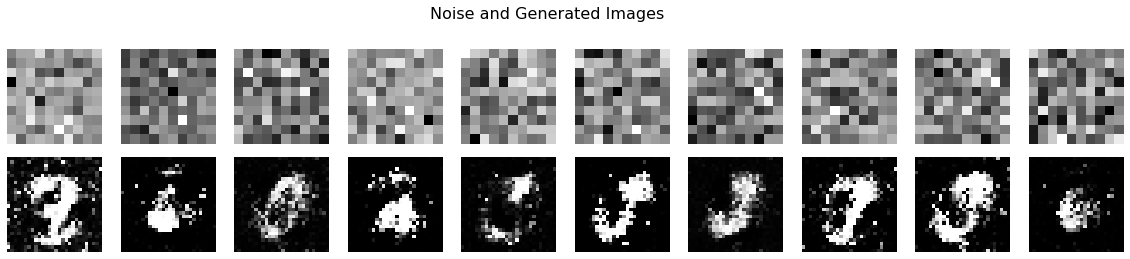

In [589]:
run(config)